In [1]:
%matplotlib inline
from selenium import webdriver
import urllib.request
import time
import os
import boto3
import json
import matplotlib.pyplot as plt
from utils import *

In [2]:
# images of our congressmen
URL = "https://en.wikipedia.org/wiki/List_of_current_members_of_the_United_States_House_of_Representatives"

# where to save our images of congressmen
IMAGE_DIR = "../images/congress"

# where to save our mugshots
NIST_DIR = "../images/nist/"

# Where to save the output of our congressmen compared to our mugshots
DATA_DIR = "../data/congress"

# subdirectory of clean congress filenames
CLEAN = "clean"

# subdirectory of original congress filenames
DIRTY = "dirty"

# name of our s3 bucket where we'll store our mugshots for upload to Rekog
S3_BUCKET = "nist-mugshots"

# collection id of our rekognition index
COLLECTION_ID = "congress"

## Download Congressmen Images

In [3]:
congress_dir = os.path.join(IMAGE_DIR, CLEAN)
dirty_dir = os.path.join(IMAGE_DIR, DIRTY)
clean_dir = os.path.join(IMAGE_DIR, CLEAN)

In [108]:
browser = webdriver.Firefox()

In [110]:
browser.get(URL)
time.sleep(1)

links = [c.get_attribute("href") for c in browser.find_elements_by_xpath('//a[@class="image"]')[1:]]

for link in links:
    browser.get(link)
    time.sleep(1)
    path = browser.find_element_by_xpath('//div[@id="file"]/a').get_attribute("href")
    filename = path.split("/")[-1]
    urllib.request.urlretrieve(path, os.path.join(dirty_dir, filename))

In [4]:
images = []

for dirpath, dirnames, filenames in os.walk(dirty_dir):
    for f in filenames:
        ext = f.split(".")[-1].lower()
        if ext in ("jpg", "jpeg", "png"):
            images.append(os.path.join(dirpath, f))

In [6]:
for f in images:
    better = f.lower()
    better = re.sub("\.jpeg", "\.jpg", better)
    better = re.sub(REGEX, "", better)
    better = re.sub("-", "_", better)
    better = re.sub("[^a-zA-Z\._]", "", better)
    better = re.sub("congress[a-zA-Z]+_?", "", better)
    better = re.sub("rep[a-zA-Z]+?_?\.?", "", better)
    better = re.sub("house[a-zA-Z]+?", "", better)
    better = re.sub("wiki[a-zA-Z]+_?", "", better)
    better = re.sub("official[a-zA-Z]+_?", "", better)
    better = re.sub("portrait_?", "", better)
    better = re.sub("head_?shot", "", better)
    shutil.copy(os.path.join(IMAGE_DIR, "dirty", f), os.path.join(IMAGE_DIR, "clean", better))
    # manually update some names and replace picture > 4 MB ...

## Get images of Congressmen

In [7]:
congress_paths = []
congress_images = []

for dirpath, dirnames, filenames in os.walk(congress_dir):
    for f in filenames:
        if f.endswith(".jpg"):
            congress_paths.append(os.path.join(dirpath, f))
            congress_images.append(f)

num_congress = len(congress_paths)

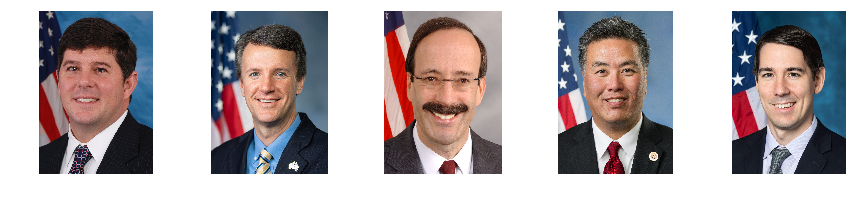

In [8]:
ncols = 5
nrows = 1

fig, axes = plt.subplots(ncols=ncols, nrows=nrows)
fig.set_size_inches(3 * ncols, 3 * nrows)

for ax, path in zip(axes.ravel(), congress_paths):
    im = plt.imread(path)
    ax.imshow(im)
    ax.axis("off")


## Index NIST Special Database 18 

In [9]:
client=boto3.client('rekognition')
s3_client=boto3.client('s3')

In [10]:
nist_images = []
nist_paths = []

for dirpath, dirnames, filenames in os.walk(NIST_DIR):
    for f in filenames:
        if f.endswith("_F.png"):
            nist_paths.append(os.path.join(dirpath, f))
            nist_images.append(f)
            
num_nist = len(nist_paths)

In [182]:
upload_files_to_s3(s3_client, S3_BUCKET, nist_paths)

In [204]:
client.create_collection(CollectionId=COLLECTION_ID)

## Uploading mugshots to collection

In [212]:
out = {}
for image in nist_images:
    
    response=client.index_faces(CollectionId=COLLECTION_ID,
                                Image={'S3Object':{'Bucket': S3_BUCKET,'Name':image}},
                                ExternalImageId=image,
                                MaxFaces=1,
                                QualityFilter="AUTO",
                                DetectionAttributes=['ALL'])
    
    out[image] = response


## Comparing Congressmen to mugshots

In [286]:
congress_out = {}

for idx, congress_path in enumerate(congress_paths):
    print(f"\r{idx}/{num_congress}", end="")
    filename = congress_path.split("/")[-1]
    if filename in congress_out:
        continue
    with open(congress_path,'rb') as f:
        image_source = f.read()

    out = client.search_faces_by_image(CollectionId=COLLECTION_ID,
                                FaceMatchThreshold=70,
                                Image={'Bytes': image_source},
                                MaxFaces=1)
    congress_out[filename] = out


439/440

## Saving comparisons

In [287]:
for k, v in congress_out.items():
    save_file = "".join(k.split(".")[:-1]) + ".json"
    save_path = os.path.join(DATA_DIR, save_file)
    with open(save_path, "w") as f:
        json.dump(v, f)

## Getting misidentified matches

In [289]:
mismatches = [(k,v) for k,v in congress_out.items() if len(v["FaceMatches"]) > 0]
num_mismatches = len(mismatches)
print(f"{num_mismatches} congressman misidentified")

10 congressman misidentified


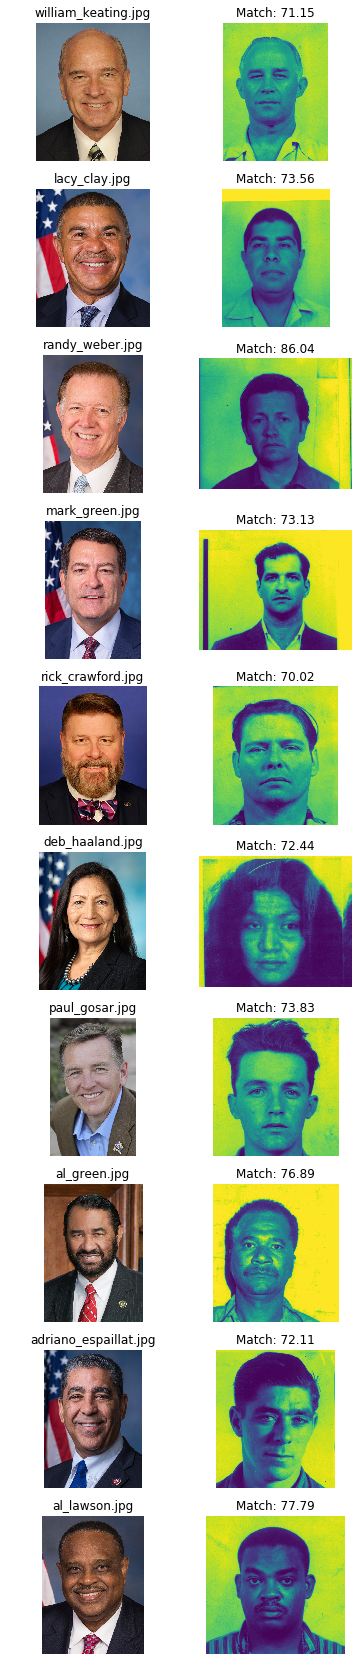

In [324]:
ncols = 2
nrows = num_mismatches

fig, axes = plt.subplots(nrows=nrows, ncols=ncols)
fig.set_size_inches(3 * ncols, 3 * nrows)

for idx, mismatch in enumerate(mismatches): 
    (file_congress, match_info) = mismatch
    path_congress = os.path.join(congress_dir, file_congress)
    
    similarity = match_info["FaceMatches"][0]["Similarity"]
    file_mugshot = match_info["FaceMatches"][0]["Face"]["ExternalImageId"]
    path_mugshot = [f for f in nist_paths if f.endswith(file_mugshot)][0]

    im_congress = plt.imread(path_congress)
    im_mugshot = plt.imread(path_mugshot)
    
    ax_congress = axes[idx,0]
    ax_mugshot = axes[idx,1]
    
    ax_congress.imshow(im_congress)
    ax_congress.axis("off")
    ax_congress.set_title(f"{file_congress}")
    
    ax_mugshot.imshow(im_mugshot)
    ax_mugshot.axis("off")
    ax_mugshot.set_title("Match: {:0.2f}".format(similarity))
    


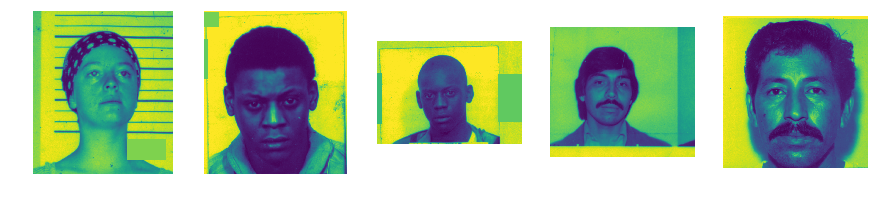

In [311]:
ncols = 5
nrows = 1

fig, axes = plt.subplots(ncols=ncols, nrows=nrows)
fig.set_size_inches(3 * ncols, 3 * nrows)

for ax, path in zip(axes.ravel(),nist_paths):
    im = plt.imread(path)
    ax.imshow(im)
    ax.axis("off")
